In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset, DataLoader
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [3]:
data_df = pd.read_csv(r"/content/drive/MyDrive/Twitter_senti/twitter_training.csv",header=None)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Twitter_senti/twitter_training.csv'

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [ ]:
data_df.dropna(inplace = True)
data_df.drop_duplicates(inplace = True)
data_df = data_df.drop(columns=data_df.columns[[0, 1]])
new_column_names = ['label', 'text']
data_df.columns = new_column_names
data_df = data_df.loc[data_df['label'] != 'Irrelevant'].copy()
data_df['label'] = label_encoder.fit_transform(data_df['label'])
print(len(data_df))

59119


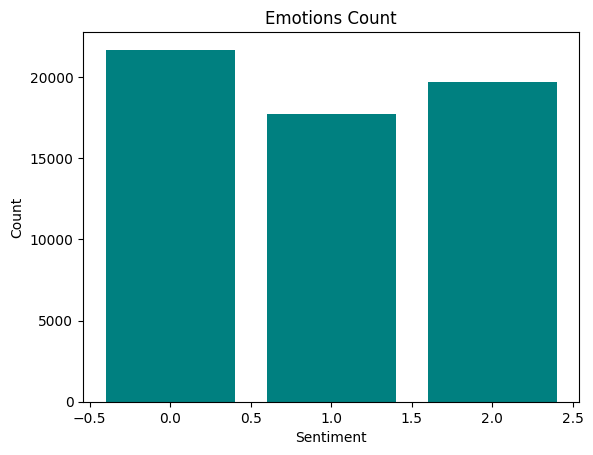

[21698, 19713, 17708]


In [ ]:
data_df.head()

emotions_count = data_df['label'].value_counts()
plt.bar(list(emotions_count.keys()), list(emotions_count), color='teal')
plt.xlabel("Sentiment",)
plt.ylabel('Count')
plt.title('Emotions Count')
plt.show()
print(list(emotions_count))

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def clean_text(text, stem=True):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return text



tokenizer = get_tokenizer('basic_english')
train_data = data_df['text'].apply(clean_text).apply(tokenizer)
data_df['tokens'] = train_data
print(data_df['tokens'][:4])
print(data_df['label'][:4])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    [im, getting, on, borderlands, and, i, will, m...
1    [i, am, coming, to, the, borders, and, i, will...
2    [im, getting, on, borderlands, and, i, will, k...
3    [im, coming, on, borderlands, and, i, will, mu...
Name: tokens, dtype: object
0    2
1    2
2    2
3    2
Name: label, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data_df, test_size=0.2, shuffle=True, random_state = 123)
print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

label
0    17421
2    15802
1    14072
Name: count, dtype: int64
label
0    4277
2    3911
1    3636
Name: count, dtype: int64


In [ ]:
def build_vocab(texts):
        all_tokens = [token for text in texts for token in text]
        vocab = {token: idx for idx, token in enumerate(set(all_tokens))}
        vocab['<pad>'] = len(vocab)
        print(f"Vocabulary Length is: {len(vocab)}")
        return vocab, len(vocab)

vocab, VOCAB_SIZE = build_vocab(train_data)

Vocabulary Length is: 32475


In [ ]:
BATCH_SIZE = 32
HIDDEN_DIM = 256
MAX_LEN = 50
EMBED_DIM = 128
pad_index = vocab["<pad>"]

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab=None, max_len = MAX_LEN, pad_token = '<pad>'):
        self.texts = texts
        self.pad_token = pad_token
        self.max_length = max_len
        self.labels = labels
        self.vocab = vocab

    def text_to_tensor(self, text):
        text_indices = [self.vocab.get(token) for token in text]

        if len(text_indices) < self.max_length:
            text_indices = text_indices + [self.vocab[self.pad_token]] * (self.max_length - len(text_indices))
        else:
            text_indices = text_indices[:self.max_length]
        return torch.tensor(text_indices, dtype=torch.long)

    def label_to_tensor(self, label):
        return torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return self.text_to_tensor(text), self.label_to_tensor(label)

train_dataset = TextDataset(train_df['tokens'].tolist(), train_df['label'].tolist(), vocab = vocab)
test_dataset = TextDataset(test_df['tokens'].tolist(), test_df['label'].tolist(), vocab = vocab)

for text_tensor, label_tensor in test_dataset:
    print(f"text_tensor: {text_tensor}")
    print(f"label_tensor: {label_tensor}")
    tokenized_tensor = text_tensor
    break


text_tensor: tensor([24449, 17007, 14545, 20597, 11513,   989,  3096, 20597, 14409, 25084,
        10192, 23050,  2204,  9097, 32474, 32474, 32474, 32474, 32474, 32474,
        32474, 32474, 32474, 32474, 32474, 32474, 32474, 32474, 32474, 32474,
        32474, 32474, 32474, 32474, 32474, 32474, 32474, 32474, 32474, 32474,
        32474, 32474, 32474, 32474, 32474, 32474, 32474, 32474, 32474, 32474])
label_tensor: 1


In [ ]:
reverse_vocab = {v: k for k, v in vocab.items()}

# Function to convert tensor to sentence
def tensor_to_sentence(tensor):
    tokens = [reverse_vocab[idx.item()] for idx in tensor if idx.item() in reverse_vocab]
    return ' '.join(tokens)

print(tensor_to_sentence(tokenized_tensor))

dota three of the strongest players at the leipzig major esports for us esportsforuscomdotathreeo <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [ ]:
device = ('cuda'
          if torch.cuda.is_available()
          else "mps"
          if torch.backends.mps.is_available()
          else "cpu"
          )


print(f"Using Device: {device}")

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

n = 0
for X, Y in test_dataloader:
    n+=1
    if n > 5:
        break
    else:
        print(f"Shape of X: {tensor_to_sentence(X[0])}")
        print(f"Shape of Y: {Y[0]}")

Using Device: cpu
Shape of X: dota three of the strongest players at the leipzig major esports for us esportsforuscomdotathreeo <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Shape of Y: 1
Shape of X: i also die for kindred <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Shape of Y: 2
Shape of X: odd rogue wild used this to hit legend times this month winrate the oneofs are flex spots there are a lot of good cards you can swap in and out in wild this final version is the best i think playhearthstone pictwittercomvefmebmj <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Shape of Y: 2
Shape of X: all of t

In [ ]:
class GRUModel(nn.Module):
    def __init__(self):
            super().__init__()
            self.embedding = nn.Embedding(VOCAB_SIZE, EMBED_DIM)
            self.gru = nn.GRU(EMBED_DIM, HIDDEN_DIM, dropout=0.3, batch_first=True)
            self.fc = nn.Linear(HIDDEN_DIM, 3)
            self.dropout = nn.Dropout(0.3)
            self.sigmoid = nn.Sigmoid()
            self.no_layers = 1



    def forward(self, x, hidden):
            batch_size = x.size(0)
            embedded = self.embedding(x)
            output, hidden = self.gru(embedded)
            output = self.dropout(output[:, -1])
            output = self.fc(output)


            return output, hidden

    def init_hidden(self, batch_size):

        h0 = torch.zeros((self.no_layers,batch_size,HIDDEN_DIM)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,HIDDEN_DIM)).to(device)
        hidden = (h0,c0)
        return hidden

In [ ]:
gru_model = GRUModel().to(device)
print(gru_model)

GRUModel(
  (embedding): Embedding(32475, 128)
  (gru): GRU(128, 256, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
for X, Y in test_dataloader:
    X = X.to(device)
    Y = Y.to(device)
    h = gru_model.init_hidden(BATCH_SIZE)
    h = tuple([each.data for each in h])
    pred, h = gru_model(X, h)
    print(f"Shape of X: {tensor_to_sentence(X[1])}")
    print(f"Shape of Y: {Y.shape}")
    print(f"pred shape: {pred.shape}")
    break

Shape of X: the borderlands ports on switch are so good that i have no complaints its definitely worth it i cant wait to get bioshock collection next <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Shape of Y: torch.Size([32])
pred shape: torch.Size([32, 3])


In [ ]:
loss_func_gru = torch.nn.CrossEntropyLoss().to(device)
optimizer_gru = torch.optim.Adam(gru_model.parameters(), lr=1e-3)

In [ ]:
def get_accuracy(pred,label):
    pred = pred.argmax(1)
    return torch.sum(pred == label).item()

In [ ]:
CLIP = 1

def train(dataloader, model, loss_fn, optimizer, train_losses):
    size = len(dataloader.dataset)
    model.train()
    h = model.init_hidden(BATCH_SIZE)
    loss_sum = 0
    accuracy = 0
    num_batches = len(dataloader)
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        h = tuple([each.data for each in h])
        pred, h = model(x, h)
        loss = loss_fn(pred, y)
        loss_sum += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()
        optimizer.zero_grad()
        accuracy += get_accuracy(pred, y)
        if batch % 200 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

    mean_loss = loss_sum / num_batches
    accuracy /= size
    train_losses.append(mean_loss)
    print(f"Training loss: {mean_loss:>7f}")
    print(f"Training accuracy: {(accuracy*100):>7f}")



In [ ]:
def test(dataloader, model, loss_fn, test_losses):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, accuracy = 0, 0
    h = model.init_hidden(BATCH_SIZE)
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            h = tuple([each.data for each in h])
            pred, h = model(x, h)
            test_loss += loss_fn(pred, y).item()
            accuracy += get_accuracy(pred, y)
    test_loss /= num_batches
    accuracy /= size
    print("________")
    print(f"Test loss: {test_loss:>7f}")
    print(f"Test accuracy: {(accuracy*100):>0.1f}%")
    test_losses.append(test_loss)

In [ ]:
train_losses = []
test_losses = []

for i in range(10):
    print(f'Epoch {i} -----------------------------------')
    train(train_dataloader, gru_model, loss_func_gru, optimizer_gru, train_losses)
    test(test_dataloader, gru_model, loss_func_gru, test_losses)

print('Finished Training')

Epoch 0 -----------------------------------
loss: 1.108492 [   32/47295]
loss: 1.152701 [ 6432/47295]
loss: 0.717768 [12832/47295]
loss: 0.811162 [19232/47295]
loss: 0.794553 [25632/47295]
loss: 0.935500 [32032/47295]
loss: 0.598648 [38432/47295]
loss: 0.715514 [44832/47295]
Training loss: 0.847969
Training accuracy: 60.207210
________
Test loss: 0.623610
Test accuracy: 74.0%
Epoch 1 -----------------------------------
loss: 0.550792 [   32/47295]
loss: 0.749802 [ 6432/47295]
loss: 0.251407 [12832/47295]
loss: 0.456569 [19232/47295]
loss: 0.373775 [25632/47295]
loss: 0.487079 [32032/47295]
loss: 0.255828 [38432/47295]
loss: 0.434199 [44832/47295]
Training loss: 0.442671
Training accuracy: 82.514008
________
Test loss: 0.446704
Test accuracy: 82.8%
Epoch 2 -----------------------------------
loss: 0.310158 [   32/47295]
loss: 0.360658 [ 6432/47295]
loss: 0.090528 [12832/47295]
loss: 0.154634 [19232/47295]
loss: 0.101211 [25632/47295]
loss: 0.363309 [32032/47295]
loss: 0.155581 [38432/47

In [ ]:
print(train_losses)


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
for X, Y in test_dataloader:
    X = X.to(device)
    Y = Y.to(device)
    h = gru_model.init_hidden(BATCH_SIZE)
    h = tuple([each.data for each in h])
    pred, h = gru_model(X, h)
    print(f"Shape of X: {tensor_to_sentence(X[10])}")
    print(f"Shape of Y: {Y[10]}")
    print(f"pred shape: {pred[10]}")
    x = X
    y = Y
    break

Shape of X: grand theft city one hold ps youtubetvdwipwlzxm <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Shape of Y: 1
pred shape: tensor([-2.2174, -1.4602,  4.2927], grad_fn=<SelectBackward0>)


tensor([1, 1, 0, 2, 0, 2, 0, 0, 0, 1, 1, 1, 2, 0, 2, 0, 0, 0, 1, 1, 1, 2, 1, 1,
        2, 1, 2, 2, 1, 0, 0, 1])
tensor([1, 1, 0, 2, 0, 2, 0, 0, 0, 1, 2, 1, 2, 0, 2, 0, 0, 0, 1, 1, 2, 2, 1, 1,
        2, 1, 2, 2, 0, 0, 0, 1])


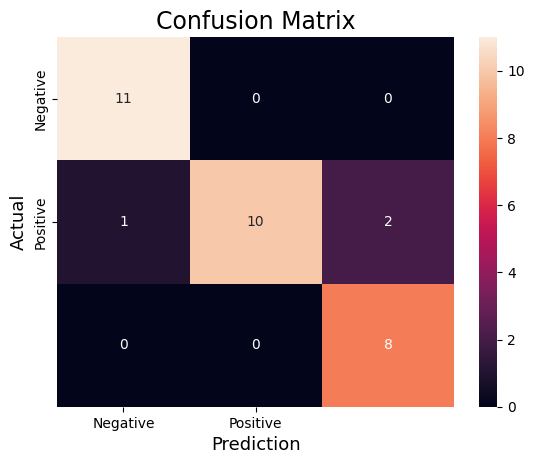

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix on 1 batch in the validation set

h = gru_model.init_hidden(BATCH_SIZE)
h = tuple([each.data for each in h])
predicted, h = gru_model(x, h)
print(y)
print(predicted.argmax(1))
y = y.cpu().detach().numpy()
cm = confusion_matrix(y, predicted.argmax(1).cpu().detach().numpy())
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()